In [1]:
!pip install transformers datasets

In [3]:
from google.colab import files
uploaded = files.upload()

Saving ECHR_Corpus.json to ECHR_Corpus.json


In [27]:
import random

def load_3class_examples(json_path, negative_ratio=1.0):
    with open(json_path, "r", encoding="utf-8") as f:
        documents = json.load(f)  # list of dicts

    examples = []

    for doc in documents:
        text = doc["text"]
        clause_map = {c["_id"]: text[c["start"]:c["end"]].strip() for c in doc["clauses"]}

        # Track which clause IDs are used as premises or conclusions
        premises_ids = set()
        conclusions_ids = set()
        for arg in doc["arguments"]:
            conclusions_ids.add(arg["conclusion"])
            premises_ids.update(arg["premises"])

        # Add premises labeled 1
        for pid in premises_ids:
            clause_text = clause_map.get(pid, "")
            if clause_text:
                examples.append({"text": clause_text, "label": 1})  # Premise

        # Add conclusions labeled 2
        for cid in conclusions_ids:
            clause_text = clause_map.get(cid, "")
            if clause_text:
                examples.append({"text": clause_text, "label": 2})  # Conclusion

        # Add negative (non-argument) samples labeled 0
        all_ids = set(clause_map.keys())
        non_argument_ids = list(all_ids - premises_ids - conclusions_ids)

        # Sample negative examples up to negative_ratio * number_of_positive_examples
        num_negatives = int(negative_ratio * (len(premises_ids) + len(conclusions_ids)))
        sampled_negatives = random.sample(non_argument_ids, min(num_negatives, len(non_argument_ids)))

        for nid in sampled_negatives:
            clause_text = clause_map.get(nid, "")
            if clause_text:
                examples.append({"text": clause_text, "label": 0})  # Non-Argument

    random.shuffle(examples)
    return examples


In [29]:
# Load examples from JSON file
examples = load_3class_examples("ECHR_Corpus.json", negative_ratio=1.0)

# Print how many examples loaded
print(f"Loaded {len(examples)} examples")

# Display first 5 examples
for i, example in enumerate(examples[:5]):
    print(f"Example {i+1}")
    print(f"Text : {example['text']}")
    print(f"Label: {example['label']}")
    print("---")


Loaded 5381 examples
Example 1
Text : On the other hand, insofar as the facts complained of relate to
the period after 7 September 1992, the application cannot be declared
inadmissible as being incompatible ratione temporis with the provisions
of the Convention.
Label: 1
---
Example 2
Text : He did not avail himself of this
possibility.
Label: 0
---
Example 3
Text : The Court is of the view that, in a situation such as that of the applicant, where a substantial term of imprisonment may be at stake and where characteristics pertaining to his personality and level of maturity are of importance in deciding on his dangerousness, Article 5 para. 4 (art. 5-4) requires an oral hearing in the context of an adversarial procedure involving legal representation and the possibility of calling and questioning witnesses.
Label: 1
---
Example 4
Text : In a letter of 18 November 1992 to the Prosecutor-General the applicant, referring to Article 180 of the Code of Criminal Procedure, complained about t

In [30]:
from datasets import Dataset
from transformers import AutoTokenizer

model_name = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Convert list of dicts to HuggingFace Dataset
dataset = Dataset.from_list(examples)

def tokenize_fn(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/5381 [00:00<?, ? examples/s]

In [11]:
# 80/20 train-validation split
#split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
#train_dataset = split_dataset['train']
#eval_dataset = split_dataset['test']

In [31]:
split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split["train"]
test_dataset = split["test"]

In [32]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

label_map = {0: "Non-Argument", 1: "Premise", 2: "Conclusion"}

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [34]:
!pip install --upgrade transformers

In [41]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model for sequence classification (3 classes)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # Non-Argument, Premise, Conclusion
    id2label={0: "Non-Argument", 1: "Premise", 2: "Conclusion"},
    label2id={"Non-Argument": 0, "Premise": 1, "Conclusion": 2}
)

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
training_args = TrainingArguments(
    output_dir="./legal-bert-argument-classifier",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",  # Changed from evaluation_strategy
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42,
    # Remove fp16 and report_to for older versions compatibility
)

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,  # Updated from 'tokenizer' to avoid deprecation warning
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Print dataset info
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Check label distribution
train_labels = train_dataset["label"]
test_labels = test_dataset["label"]


Training samples: 4304
Test samples: 1077


In [46]:
from collections import Counter
train_dist = Counter(train_labels)
test_dist = Counter(test_labels)

print("\nLabel distribution in training set:")
for label, count in train_dist.items():
    print(f"  {label_map[label]}: {count} ({count/len(train_labels)*100:.1f}%)")

print("\nLabel distribution in test set:")
for label, count in test_dist.items():
    print(f"  {label_map[label]}: {count} ({count/len(test_labels)*100:.1f}%)")

# Start training
print("\nStarting training...")
trainer.train()

# Evaluate on test set
print("\nEvaluating on test set...")
eval_results = trainer.evaluate()

print("\nFinal Results:")
for key, value in eval_results.items():
    print(f"  {key}: {value:.4f}")


Label distribution in training set:
  Conclusion: 586 (13.6%)
  Non-Argument: 2158 (50.1%)
  Premise: 1560 (36.2%)

Label distribution in test set:
  Premise: 391 (36.3%)
  Non-Argument: 529 (49.1%)
  Conclusion: 157 (14.6%)

Starting training...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.650800,0.678068,0.702878,0.742600,0.702878,0.710129



Evaluating on test set...



Final Results:
  eval_loss: 0.6781
  eval_accuracy: 0.7029
  eval_precision: 0.7426
  eval_recall: 0.7029
  eval_f1: 0.7101
  eval_runtime: 15.7133
  eval_samples_per_second: 68.5410
  eval_steps_per_second: 2.1640
  epoch: 3.0000


In [47]:
model.save_pretrained("./legal-bert-argument-classifier")
tokenizer.save_pretrained("./legal-bert-argument-classifier")
print("\nModel and tokenizer saved to ./legal-bert-argument-classifier")


Model and tokenizer saved to ./legal-bert-argument-classifier


In [48]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_map.values())))


Detailed Classification Report:
              precision    recall  f1-score   support

Non-Argument       0.84      0.80      0.82       529
     Premise       0.74      0.55      0.63       391
  Conclusion       0.42      0.77      0.55       157

    accuracy                           0.70      1077
   macro avg       0.67      0.71      0.66      1077
weighted avg       0.74      0.70      0.71      1077



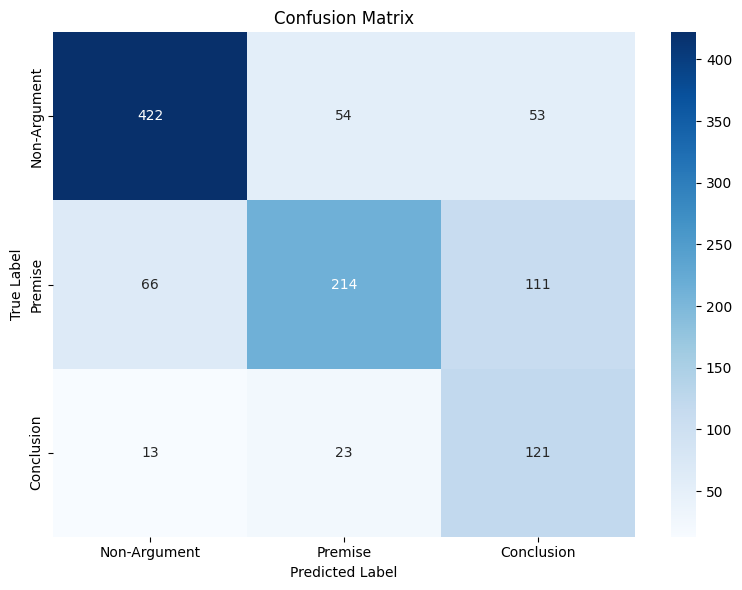

In [51]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
# Function to test on new examples
def predict_argument_type(text):
    """Predict argument type for new text"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)

    # Move inputs to the same device as the model
    device = next(model.parameters()).device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()

    return {
        "text": text,
        "predicted_label": label_map[predicted_class],
        "confidence": confidence,
        "all_probabilities": {
            label_map[i]: prob.item()
            for i, prob in enumerate(predictions[0])
        }
    }

In [56]:
test_examples = [
    "The court finds that the defendant violated Article 8 of the Convention.",
    "Therefore, the application should be dismissed as inadmissible.",
    "The weather was particularly cold that winter morning."
]

print("\n" + "="*50)
print("TESTING ON NEW EXAMPLES")
print("="*50)

for example in test_examples:
    result = predict_argument_type(example)
    print(f"\nText: {result['text']}")
    print(f"Prediction: {result['predicted_label']} (confidence: {result['confidence']:.3f})")
    print("All probabilities:")
    for label, prob in result['all_probabilities'].items():
        print(f"  {label}: {prob:.3f}")
    print("-" * 40)


TESTING ON NEW EXAMPLES

Text: The court finds that the defendant violated Article 8 of the Convention.
Prediction: Conclusion (confidence: 0.623)
All probabilities:
  Non-Argument: 0.328
  Premise: 0.049
  Conclusion: 0.623
----------------------------------------

Text: Therefore, the application should be dismissed as inadmissible.
Prediction: Conclusion (confidence: 0.873)
All probabilities:
  Non-Argument: 0.089
  Premise: 0.038
  Conclusion: 0.873
----------------------------------------

Text: The weather was particularly cold that winter morning.
Prediction: Non-Argument (confidence: 0.944)
All probabilities:
  Non-Argument: 0.944
  Premise: 0.036
  Conclusion: 0.020
----------------------------------------


In [59]:
# Download the entire model folder
from google.colab import files
import shutil
# Create a zip of the model folder
shutil.make_archive("legal-bert-argument-classifier", 'zip', "./legal-bert-argument-classifier")
files.download("legal-bert-argument-classifier.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
# Download the confusion matrix visualization
files.download("confusion_matrix.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
# Save the demo script to a file and download it
demo_code = '''#!/usr/bin/env python3
"""
Argument Mining Classifier - Classroom Demo
============================================
This script demonstrates a trained BERT model that classifies legal text into:
- Non-Argument (0): Regular text that doesn't make an argument
- Premise (1): Supporting evidence or reasoning
- Conclusion (2): Final decision or judgment
"""

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os

class ArgumentClassifier:
    def __init__(self, model_path="./legal-bert-argument-classifier"):
        """Initialize the argument classifier"""
        print("Loading trained model...")

        if not os.path.exists(model_path):
            print(f"❌ Model not found at {model_path}")
            print("Please ensure the model files are in the correct directory.")
            return

        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_path)
            self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.model.to(self.device)
            self.model.eval()

            self.label_map = {0: "Non-Argument", 1: "Premise", 2: "Conclusion"}
            print(f"✅ Model loaded successfully on {self.device}")

        except Exception as e:
            print(f"❌ Error loading model: {e}")

    def predict(self, text):
        """Predict argument type for given text"""
        if not hasattr(self, 'model'):
            return None

        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=256
        )

        inputs = {key: value.to(self.device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(probabilities, dim=-1).item()
            confidence = probabilities[0][predicted_class].item()

        return {
            "text": text,
            "prediction": self.label_map[predicted_class],
            "confidence": confidence,
            "probabilities": {
                self.label_map[i]: prob.item()
                for i, prob in enumerate(probabilities[0])
            }
        }

    def demo_examples(self):
        """Run demo with predefined examples"""
        examples = [
            "The Court finds that there has been a violation of Article 8 of the Convention.",
            "Therefore, the application must be dismissed as inadmissible.",
            "The applicant was detained without access to a lawyer for 48 hours.",
            "Article 6 of the Convention guarantees the right to a fair trial.",
            "The hearing was scheduled for Tuesday morning at 10 AM.",
            "It was raining heavily on the day of the incident."
        ]

        print("\\n" + "="*60)
        print("🎯 ARGUMENT MINING CLASSIFIER DEMO")
        print("="*60)

        for i, example in enumerate(examples, 1):
            print(f"\\n📝 Example {i}:")
            print(f"Text: \\"{example}\\"")

            result = self.predict(example)
            if result:
                colors = {"Non-Argument": "🔵", "Premise": "🟡", "Conclusion": "🟢"}
                print(f"Prediction: {colors[result['prediction']]} {result['prediction']}")
                print(f"Confidence: {result['confidence']:.3f}")

                print("Probabilities:")
                for label, prob in result['probabilities'].items():
                    bar_length = int(prob * 20)
                    bar = "█" * bar_length + "░" * (20 - bar_length)
                    print(f"  {label:12}: {bar} {prob:.3f}")

            print("-" * 50)

def main():
    print("🏛️ Legal Argument Mining with BERT")
    classifier = ArgumentClassifier()

    if hasattr(classifier, 'model'):
        classifier.demo_examples()

        # Interactive mode
        print("\\n🔄 Interactive mode - Enter text to classify ('quit' to exit):")
        while True:
            try:
                user_input = input("\\n📝 Enter text: ").strip()
                if user_input.lower() in ['quit', 'exit', 'q']:
                    break

                if user_input:
                    result = classifier.predict(user_input)
                    if result:
                        print(f"🎯 Prediction: {result['prediction']}")
                        print(f"📊 Confidence: {result['confidence']:.3f}")
            except KeyboardInterrupt:
                break

if __name__ == "__main__":
    main()
'''

with open("argument_classifier_demo.py", "w") as f:
    f.write(demo_code)

files.download("argument_classifier_demo.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
# Create requirements.txt
requirements = """torch>=1.9.0
transformers>=4.21.0
numpy>=1.21.0
scikit-learn>=1.0.0
matplotlib>=3.5.0
seaborn>=0.11.0
"""

with open("requirements.txt", "w") as f:
    f.write(requirements)

files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>